In [4]:
import requests, re
import urllib.parse as urlp

from graphviz import Digraph
from bs4 import BeautifulSoup as bs
from palettable.tableau import Tableau_20

In [73]:
base_url = "https://en.wikipedia.org/"
redirects = {}
DEBUG_LEVEL=2
house_color_map = Tableau_20.hex_colors

In [59]:
redify = lambda s: "\x1b[31m"+s+"\x1b[0m"
flattened = lambda l: [item for sublist in l for item in sublist]
log = lambda *args: print(*args) if DEBUG_LEVEL > 1 else None
error = lambda *args: print(*args) if DEBUG_LEVEL > 0 else None


In [31]:
class Person:
    def __init__(self, name, path):
        self.name = name
        self.path = path
        self.titles = None
        self.father = None
        self.mother = None
        self.spouse = []
        self.issue = []
        self.successor = []
        self.predecessor = []
        self.house = None
    def __repr__(self):
        return "Person(%s, %s)" % (self.name, self.path)
    def __eq__(self, other):
        if isinstance(other, Person):
            return (self.path.split(',')[0].lower() == other.path.split(',')[0].lower())
        else:
            return False
    def __ne__(self, other):
        return (not self.__eq__(other))
    def __hash__(self):
        return hash(self.path)
        
class Peon:
    def __init__(self, name, path = ''):
        self.name = name
        self.path = path
    def __repr__(self):
        return "Peon(%s, %s)" % (self.name, self.path)
    def __eq__(self, other):
        if isinstance(other, Peon):
            return (self.path.split(',')[0].lower() == other.path.split(',')[0].lower())
        else:
            return False
    def __ne__(self, other):
        return (not self.__eq__(other))
    def __hash__(self):
        return hash(self.path)

In [33]:
class Queue:
    
    def __init__(self):
        self.to_create = set()
        self.new = set()
        self.finished = set()
    def stage(self, p):
        self.new.add(p)
    def commit(self):
        tmp = self.new.difference(self.finished)
        self.to_create.update(tmp)
        self.new = set()
    def push(self, p):
        if p not in self.finished:
            self.to_create.add(p)
    def pop(self):
        offer = self.to_create.pop()
        self.finished.add(offer)
        return offer
    def refresh(self):
        self.new = set()

In [34]:
def make_singleton(elem, queue):
    refs = elem.find_all('a')
    if len(refs) == 1:
        ret = urlp.unquote(refs[0]['href'])
        peon = Peon(refs[0].text, ret)
    else:
        ret = elem.text
        peon = Peon(ret)
    queue.stage(peon)
    return ret
    
def make_list(elem, queue):
    refs = elem.find_all('a')
    ret = []
    for ref in refs:
        r = urlp.unquote(ref['href'])
        queue.stage(Peon(ref.text, r))
        ret.append(r)
    return ret
        

In [35]:
def get_infocard(path):
    resp = requests.get(base_url + path)
    txt = resp.text
    s = bs(txt)
    p = r'\"wgPageName\":\"(.+?)\"'
    endpath = '/wiki/' + re.search(p, txt).group(1)
    infocard = s.find_all("table", class_ = "infobox vcard")[0]
    name = s.title.string.replace(' - Wikipedia', '')
    return name, infocard, endpath

In [50]:
def get_person(path, name, people, queue, onlytitled = False):
    queue.refresh()
    if path is None:
        log(redify("No path supplied:"), name)
        return False
    try:
        name, info, endpath = get_infocard(path)
        if endpath != path:
            redirects[path] = endpath
            path = endpath
            log(redify("Redirect:"), path, '->', endpath)
        person = Person(name, path)
        if person in people:
            log(redify("Already Exists:"), name, path)
            return True
        rows = info.find_all("tr")
        if 'img' in [x.name for x in rows[1].descendants]:
            person.titles = rows[2].text
        elif onlytitled:
            raise Exception('Untitled.')
        for r in rows:
            if len(r.contents) == 2 and r.contents[0].name == 'th':
                if "Mother" in r.contents[0].text:
                    person.mother = make_singleton(r.contents[1], queue)
                if "Father" in r.contents[0].text:
                    person.father = make_singleton(r.contents[1], queue)
                if "Issue" in r.contents[0].text:
                    person.issue = make_list(r.contents[1], queue)
                if "Spouse" in r.contents[0].text:
                    person.spouse = make_list(r.contents[1], queue)
                if "House" in r.contents[0].text:
                    person.house = make_singleton(r.contents[1], queue)
                if "Predecessor" in r.contents[0].text:
                    person.predecessor = make_list(r.contents[1], queue)
                if "Successor" in r.contents[0].text:
                    person.successor = make_list(r.contents[1], queue)
        people.add(person)
        log("Adding", len(queue.new), "new elements")
        queue.commit()
        return True
    except Exception as e:
        error("    ", redify("Error - "), path + ":", e)
        return False
    

In [37]:
# queue.stage(Peon("Henry VIII", "/wiki/Henry_VIII"))

# for i in range(150):
#     peon = queue.pop()
#     worked = get_person(peon.path, peon.name)
#     if not worked:
#         people.add(peon)
#     print(peon.name)

In [51]:
def collect_people(basis_person_name, basis_person_link, count=150):
    people = set()
    queue = Queue()
    queue.stage(Peon(basis_person_name, basis_person_link))
    queue.commit()
    for i in range(count):
        peon = queue.pop()
        worked = get_person(peon.path, peon.name, people, queue)
        if not worked:
            people.add(peon)
        log(peon.name)
    return people

In [66]:
# Remove extra marriage link (helps for removing edges)
def one_marriage_to_rule_them_all(marriage):
    cleaned = []
    for bond in marriage:
        if bond not in cleaned and (bond[1], bond[0]) not in cleaned:
            cleaned.append(bond)
    return cleaned

# Get actual link from redirected links
def final(x):
    return redirects[x] if x in redirects else x

# Transform list of people into graph of relations
# List of people (nodes) and lists of edges (child relationships, marriage, crown pathways)
def make_nodegraph_parts(people):
    nodes = []
    childrels = set()
    marriage = set()
    crown = set()

    relevant_people = [p for p in people if isinstance(p, Person)]
    for person in relevant_people:
        nodes.append((person.path, person.name, person.house))
        childrels.update({(person.path, final(x)) for x in person.issue})
        marriage.update({(person.path, final(x)) for x in person.spouse})
        crown.update({(person.path, final(x)) for x in person.successor})
        crown.update({(final(x),person.path) for x in person.predecessor})
        if person.mother is not None:
            childrels.add((final(person.mother), person.path))
        if person.father is not None:
            childrels.add((final(person.father), person.path))

    nodelinks = [x[0] for x in nodes]
    houses = [x[2] for x in nodes]
    crown = [x for x in crown if x[0] in nodelinks and x[1] in nodelinks]
    marriage = [x for x in marriage if x[0] in nodelinks and x[1] in nodelinks]
    childrels = [x for x in childrels if x[0] in nodelinks and x[1] in nodelinks]

    marriage = one_marriage_to_rule_them_all(marriage)
    
    return nodes, childrels, marriage, crown, houses

In [52]:
# Functions to remove non-cycle elements, so that the circular ones are really highlighted
# TODO: can probably be improved by using find-cycles graph functions instead of recursing on find-leafs

# Find unimportant people (with only one relation; graph edges)
def get_leafs(crown, marriage, childrels):
    nodepaths = crown + marriage + childrels
    relinstances = flattened(nodepaths)
    relinstances_notkids = flattened(crown + marriage) + [x[0] for x in childrels]
    leafs = [x for x in relinstances if relinstances.count(x) < 2] 
    leafs += [x for x in relinstances_notkids if relinstances_notkids.count(x) == 0]
    return list(set(leafs))

# Remove unimportant people
def remove_leafs(nodes, crown, marriage, childrels, leafs):
    nodes = [x for x in nodes if x[0] not in leafs]
    crown = [x for x in crown if x[0] not in leafs and x[1] not in leafs]
    marriage = [x for x in marriage if x[0] not in leafs and x[1] not in leafs]
    childrels = [x for x in childrels if x[0] not in leafs and x[1] not in leafs]
    return nodes, crown, marriage, childrels
    
# Recursively find and remove unimportant people
def prune(nodes, crown, marriage, childrels, backoff_limit=100):
    leafs = get_leafs(crown, marriage, childrels)
    while len(leafs)>0 and backoff_limit > 0:
        nodes, crown, marriage, childrels = remove_leafs(nodes, crown, marriage, childrels, leafs)
        log("Removed", len(leafs), "leaves")
        leafs = get_leafs(crown, marriage, childrels)
    return nodes, crown, marriage, childrels

In [ ]:
# "Henry VIII", "/wiki/Henry_VIII"

In [67]:
def get_graph(basis_person_name, basis_person_link, count=150):
    people = collect_people(basis_person_name, basis_person_link, count)
    log("Collected", len(people), "people")
    nodes, childrels, marriage, crown, houses = make_nodegraph_parts(people)
    log("Turned into", len(nodes), "nodes")
    nodes, childrels, marriage, crown = prune(nodes, childrels, marriage, crown)
    log("Pruned into", len(nodes), "nodes")
    return nodes, childrels, marriage, crown, houses

In [83]:
def get_house_colors(houses):
    top_houses = sorted([(x, houses.count(x)) for x in set(houses) if x is not None], 
                        key=lambda x: x[1], reverse=True)[:20]
    house_colors = {top_houses[i][0]:house_color_map[i] for i in range(20)}
    return house_colors

def create_diagraph(nodes, childrels, marriage, crown, houses, name="WikiRelations"):
    house_colors = get_house_colors(houses)
    dot = Digraph(comment=name)

    for p, n, h in nodes:
        dot.node(p, n, color = house_colors.get(h, "black"))

    for a, b in list(marriage):
        dot.edge(a, b, color = 'red', style = 'dashed', arrowhead = 'none')
    for a, b in list(crown):
        dot.edge(a, b, color = 'gold')
    for a, b in list(childrels):
        dot.edge(a, b, color = 'black')
        
    return dot

In [84]:
def wiki_relationship_diagraph(basis_person_name, basis_person_link, count=150,name="WikiRelations", save=True)
    nodes, childrels, marriage, crown, houses = get_graph(basis_person_name, basis_person_link, count)
    dot = create_diagraph(nodes, childrels, marriage, crown, houses)
    return dot

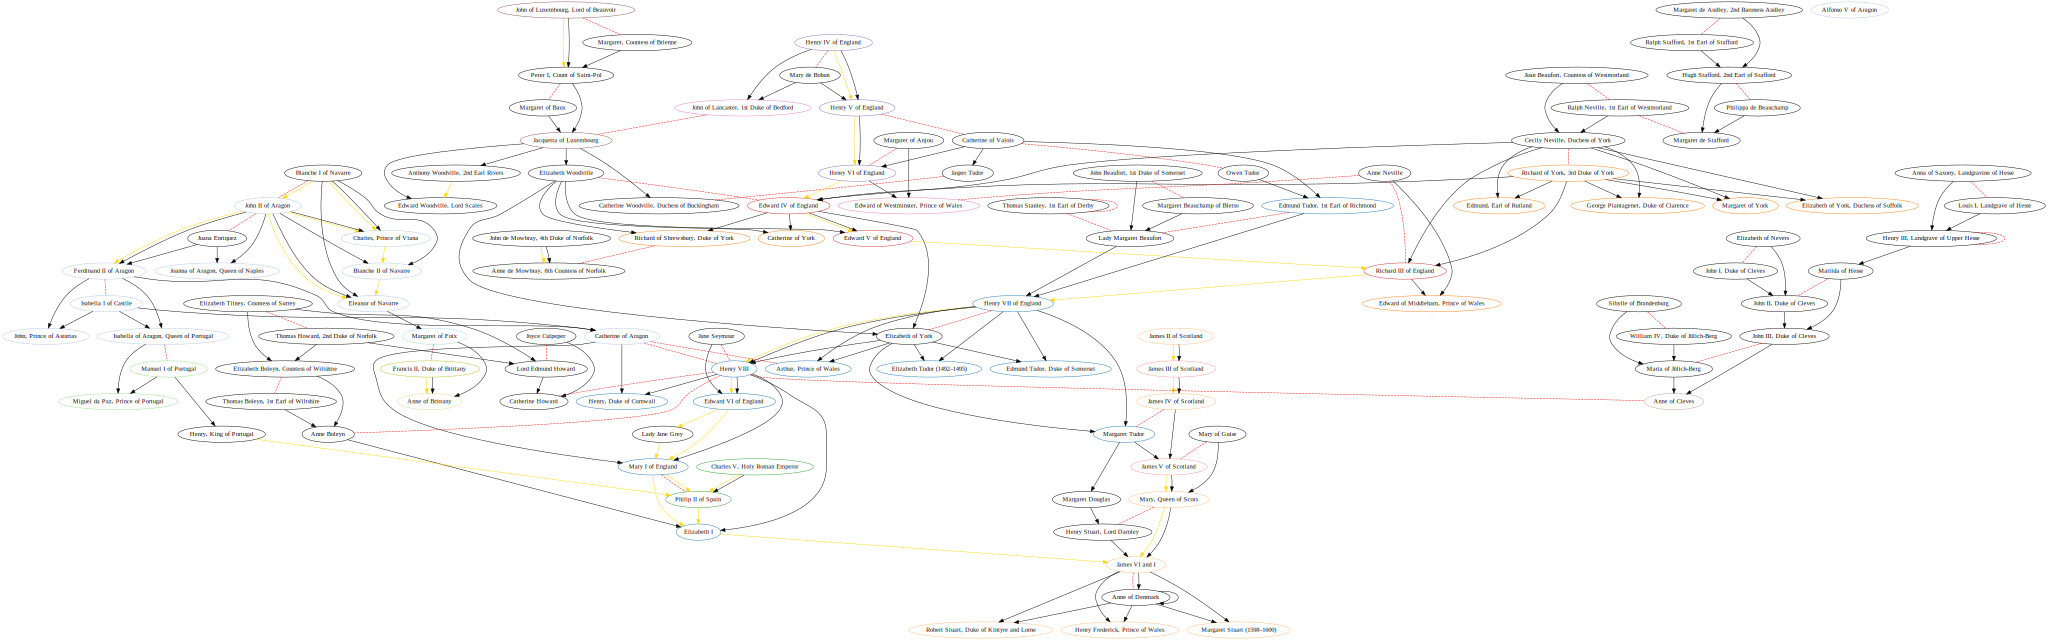

In [85]:
dot

In [296]:
marriage

[('/wiki/Francis_II_of_France', '/wiki/Mary,_Queen_of_Scots'),
 ('/wiki/James_IV_of_Scotland', '/wiki/Margaret_Tudor'),
 ('/wiki/Edward_IV_of_England', '/wiki/Elizabeth_Woodville'),
 ('/wiki/Elizabeth_Woodville', '/wiki/Edward_IV_of_England'),
 ('/wiki/Madeleine_of_Valois', '/wiki/James_V_of_Scotland'),
 ('/wiki/Margaret_Tudor', '/wiki/Henry_Stewart,_1st_Lord_Methven'),
 ('/wiki/Duchess_Charlotte_of_Brunswick-Lüneburg',
  "/wiki/Rinaldo_d'Este_(1655–1737)"),
 ('/wiki/Frances_Grey,_Duchess_of_Suffolk',
  '/wiki/Henry_Grey,_1st_Duke_of_Suffolk'),
 ('/wiki/Anna_of_Saxony,_Landgravine_of_Hesse',
  '/wiki/Louis_I,_Landgrave_of_Hesse'),
 ('/wiki/Germaine_of_Foix', '/wiki/Johann_of_Brandenburg-Ansbach'),
 ('/wiki/Frederick_V_of_the_Palatinate',
  '/wiki/Elizabeth_Stuart,_Queen_of_Bohemia'),
 ('/wiki/Jacquetta_of_Luxembourg', '/wiki/Richard_Woodville,_1st_Earl_Rivers'),
 ('/wiki/Germaine_of_Foix', '/wiki/Ferdinand_II_of_Aragon'),
 ('/wiki/John,_Prince_of_Asturias',
  '/wiki/Margaret_of_Austria

In [341]:
dot.render('test-output/round-table.gv', view=True)  

'test-output/round-table.gv.pdf'